In [1]:
import sys
import os
home = os.path.expanduser("~")
sys.path.append(f'{home}/TorchFiber')
import pickle, matplotlib.pyplot as plt, numpy as np, os
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['g',  'b', 'k', 'y', 'm', 'c'])  # type: ignore

discard = 10000
i,j = 2, 0

Q1,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/baselines.pkl', discard=discard)
cdc = Q1['CDC'][i, j,:]
Q, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor_1205/Q2000/few_test/', discard=discard)


sqz = lambda x: np.squeeze(x) if (x.shape[0]!=4) else x[i,j]

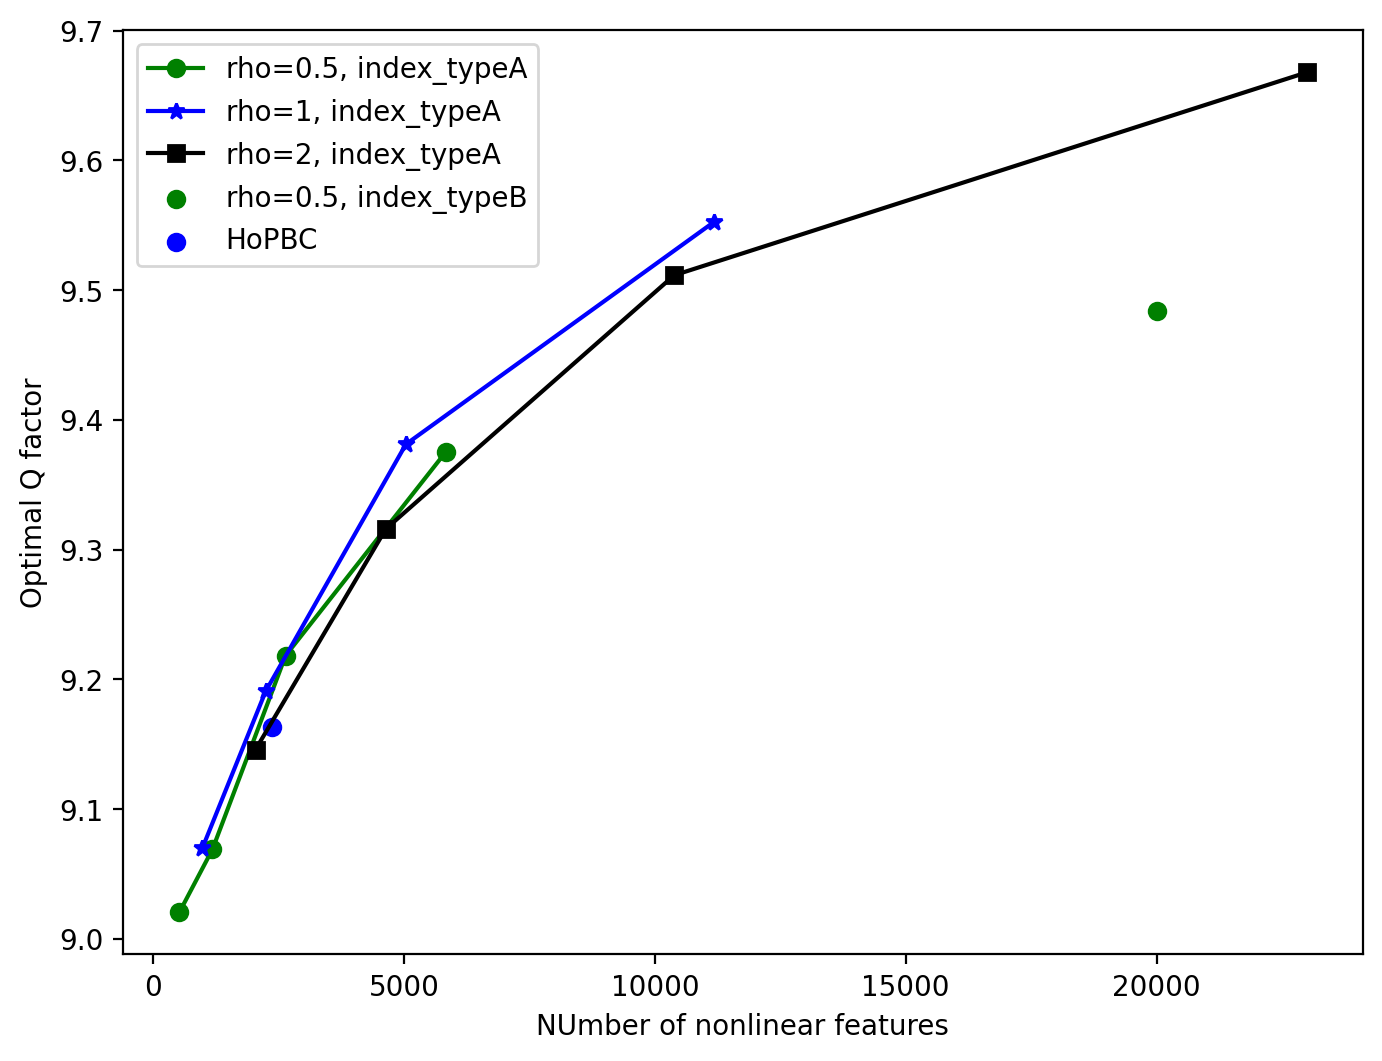

In [2]:
plt.figure(figsize=(8,6), dpi=200)
# rho=0.5, wdk=0.001, epochs=2000, lossMT, index_typeA
CC = []
Qmax = []
for L in [100, 200, 400, 800]:
    key = f'models/SymFoPBC/L{L}_rho0.5_index_typeA_lossMT_batchs19_tbpl5000_iters1_lr1e-4_wdk0.001_epochs2000'
    rho = 0.5
    CC.append(2*rho*L*np.log(rho * L/2) + 2*L)
    Qmax.append(np.max(Q[key]))
# plt.scatter(CC, Qmax, label='rho=0.5')
plt.plot(CC, Qmax, '-o', label='rho=0.5, index_typeA')

# # rho=1, wdk=0.001, epochs=2000, lossMT, index_typeA
# for key in  Q.keys():
#     if 'SymFoPBC' in key and 'rho1' in key and 'epochs50' in key and 'lossMT' in key and 'index_typeA' in key:
#         keys.append(key)

CC = []
Qmax = []
for L in [100, 200, 400, 800]:
    key = f'models/SymFoPBC/L{L}_rho1_index_typeA_lossMT_batchs18_tbpl5000_discard2000_iters1_lr1e-4_wdk0.001_lamb0_epochs50'
    rho = 1
    CC.append(2*rho*L*np.log(rho * L/2) + 2*L)
    Qmax.append(np.max(Q[key]))
# plt.scatter(CC, Qmax, label='rho=1')
plt.plot(CC, Qmax, '-*', label='rho=1, index_typeA')

# for key in  Q.keys():
#     if 'SymFoPBC/L800' in key and 'rho2' in key and 'epochs50' in key and 'lossMT' in key and 'index_typeA' in key:
#         keys.append(key)

CC = []
Qmax = []
for L in [100, 200, 400, 800]:
    key = f'models/SymFoPBC/L{L}_rho2_index_typeA_lossMT_batchs18_tbpl5000_discard2000_iters1_lr1e-4_wdk0.001_lamb0_epochs50'
    rho = 2
    CC.append(2*rho*L*np.log(rho * L/2) + 2*L)
    Qmax.append(np.max(Q[key]))
# plt.scatter(CC, Qmax, label='rho=2')
plt.plot(CC, Qmax, '-s', label='rho=2, index_typeA')



key =  'models/SymFoPBC/L200_rho0.5_index_typeB_lossMT_batchs18_tbpl5000_discard2000_iters1_lr1e-4_wdk0.001_lamb0_epochs100'
CC = 1/2*200**2
Qmax = np.max(Q[key])
plt.scatter(CC, Qmax, label='rho=0.5, index_typeB')


import torch
ckpt = torch.load('../models/SymHoPBC/L200_rho0.5_steps2_lossMT_batchs18_tbpl5000_discard2000_iters1_lr2e-4_wdk0.001_lamb0_epochs400/Nch1_Rs80.pth.ckpt400', map_location='cpu')
L = 200
rho = 0.5
CC = (2*rho*L*np.log(rho * L/2) + 2*L)*2
Qmax = np.max(ckpt['metric']['Qsq'])
plt.scatter(CC, Qmax, label='HoPBC')

plt.xlabel('NUmber of nonlinear features')
plt.ylabel('Optimal Q factor')
plt.legend()

In [10]:
import os, torch


def Qmax(lis):
    q = []
    for path in lis:
        ckpt = torch.load(f'../_models/{path}', map_location='cpu')
        q.append(np.max(ckpt['metric']['Qsq']))
    return np.max(q)


def get_CC(lis):
    ckpt = torch.load(f'../_models/{lis[0]}', map_location='cpu')
    config = ckpt['model info']
    if ckpt['model_name'] == 'SymFoPBC':
        return 2*config['rho']*config['L']*np.log(config['rho'] * config['L']/2) + 2*config['L']
    elif ckpt['model_name'] == 'SymHoPBC':
        return config['steps']*2*config['rho']*config['L']*np.log(config['rho'] * config['L']/2) + 2*config['L']
    elif ckpt['model_name'] == 'SymFoPBCNN':
        N = 2*config['rho']*config['L']*np.log(config['rho'] * config['L']/2)
        return (2*N * config['hidden_size'][0] + config['hidden_size'][0]*config['hidden_size'][1] + config['hidden_size'][1]*2)/4
    elif ckpt['model_name'] == 'SoPBC':
        L = config['L']
        L1 = config['L1']
        rho = config['rho']
        Lk = config['Lk']
        return 2*(2*Lk+1)*(2*rho*L*np.log(rho * L/2) + 2*L) + 2*rho*L1*np.log(rho * L1/2) + 2*L1
    else:
        raise NotImplementedError

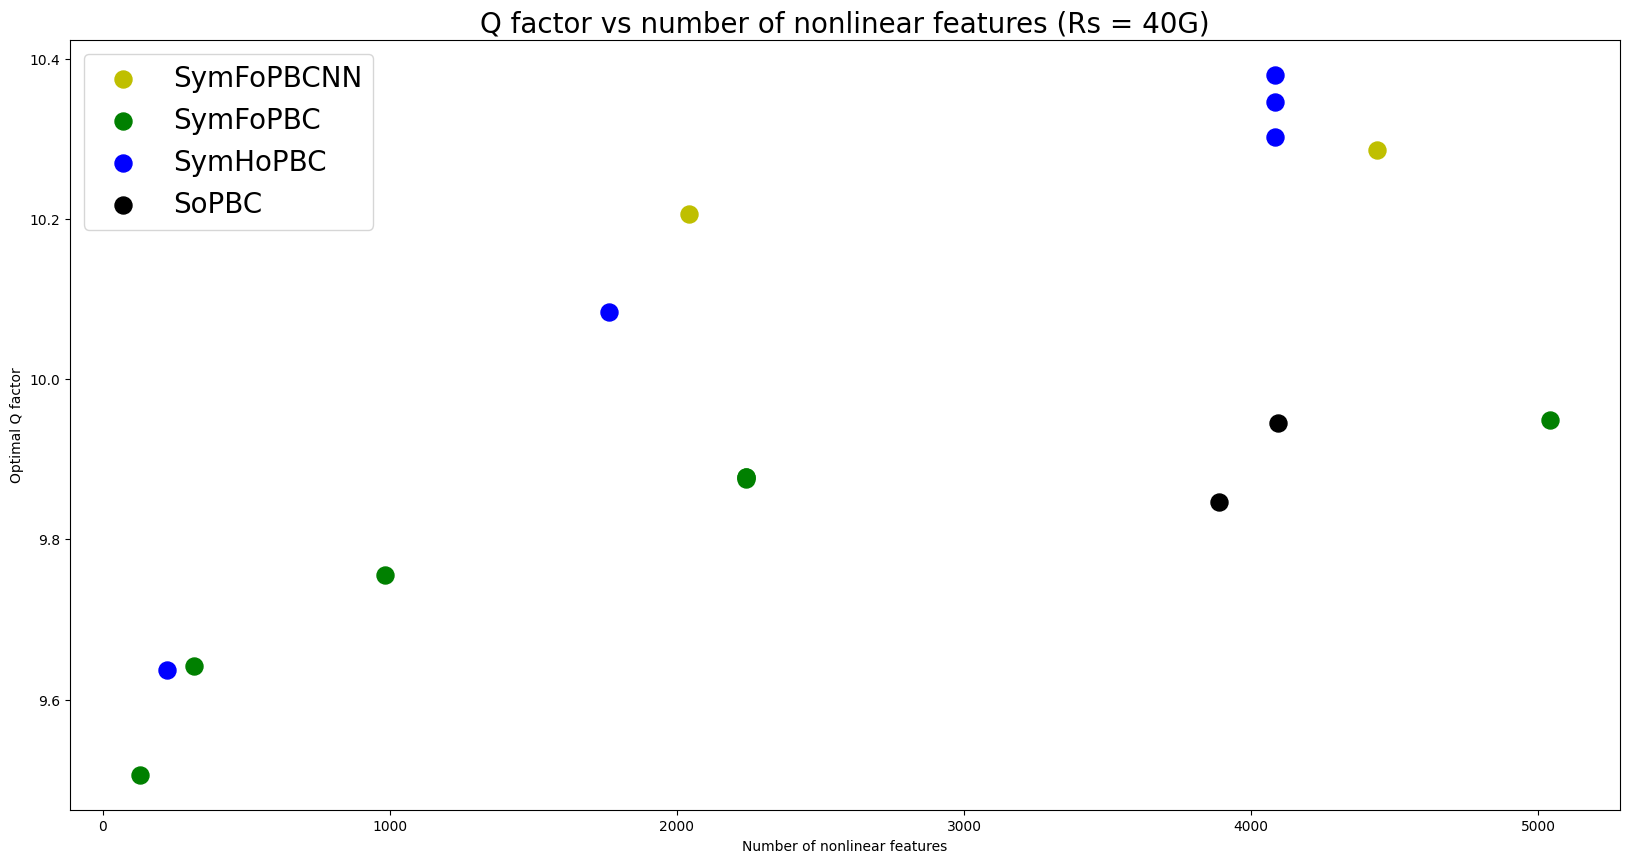

In [37]:
# 为每个不同的标签指定一个颜色
lis = os.listdir('../_models/')

dic = {}
dic = {x.split('.')[0]:[] for x in lis if 'Rs40' in x}

for key in dic.keys():
    for x in lis:
        if key in x:
            dic[key].append(x)

for key in dic.keys():
    dic[key] = sorted(dic[key])

colors = {'SymFoPBC': 'g', 'SymHoPBC': 'b', 'SymFoPBCNN': 'y', 'SoPBC': 'k'}

# 如果标签数量超过颜色列表，可以考虑使用颜色映射来生成更多颜色
added_labels = set()  # 用于跟踪已添加到图例的标签

plt.figure(figsize=(20, 10), dpi=100)
for key in dic.keys():
    label = key.split('_')[0]
    if label not in added_labels:
        plt.scatter(get_CC(dic[key]), Qmax(dic[key]), s=150, color=colors[label], label=label)
        added_labels.add(label)  # 将标签添加到集合中
    else:
        plt.scatter(get_CC(dic[key]), Qmax(dic[key]), s=150, color=colors[label])


plt.xlabel('Number of nonlinear features')
plt.ylabel('Optimal Q factor')
plt.legend(loc='upper left', fontsize=20)
plt.title('Q factor vs number of nonlinear features (Rs = 40G)', fontsize=20)
plt.savefig('../_outputs/img/Q_CC_Rs40_Nch1.png', dpi=300)

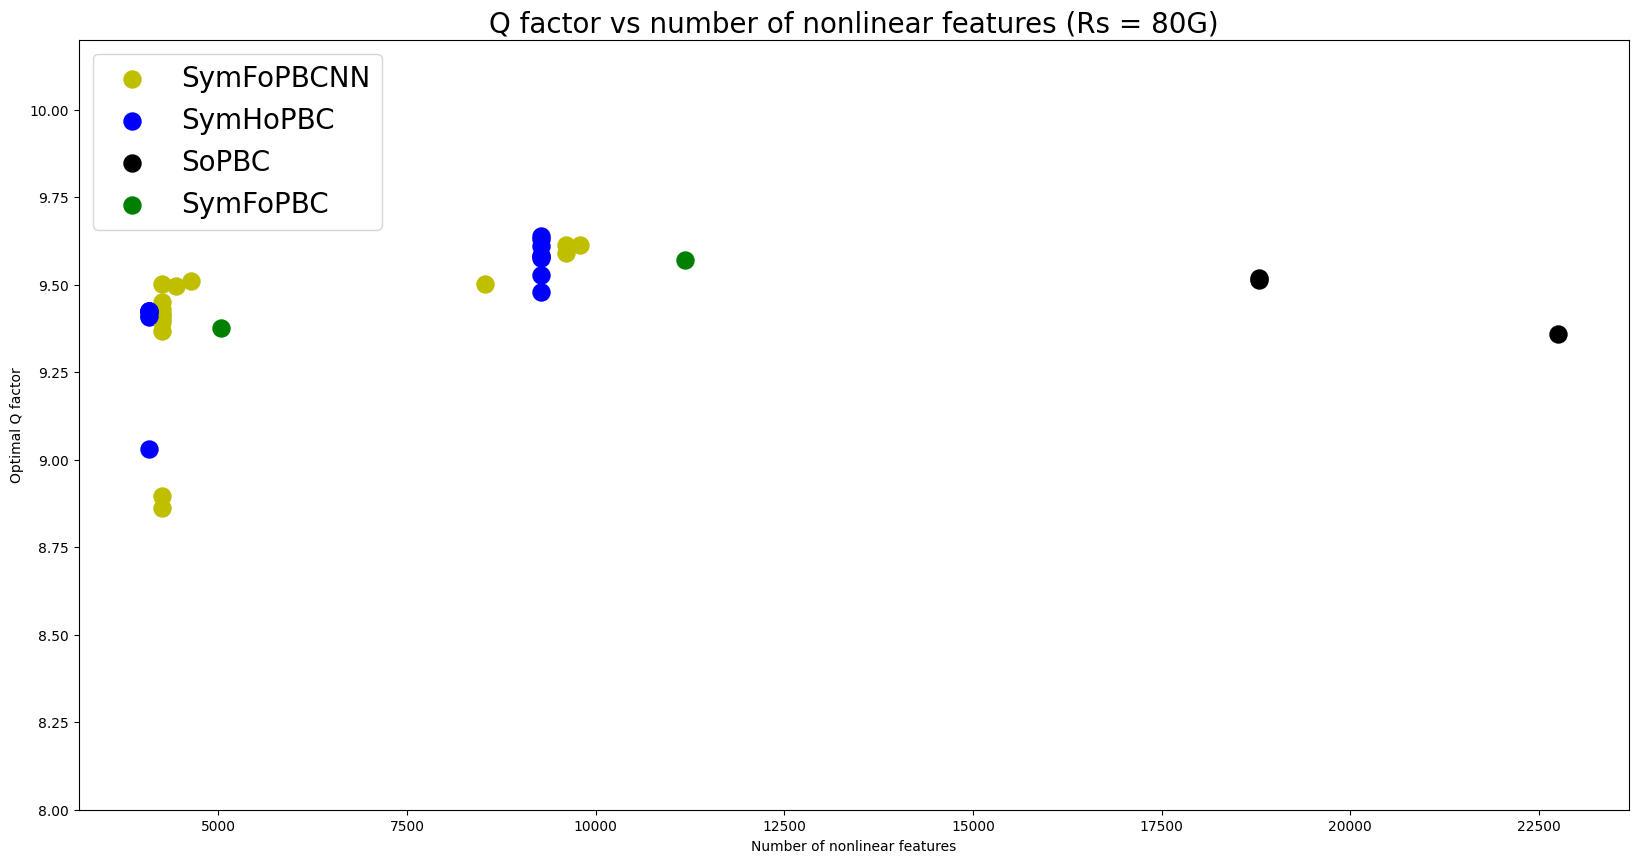

In [38]:
# 为每个不同的标签指定一个颜色
lis = os.listdir('../_models/')

dic = {}
dic = {x.split('.')[0]:[] for x in lis if 'Rs80' in x}

for key in dic.keys():
    for x in lis:
        if key in x:
            dic[key].append(x)

for key in dic.keys():
    dic[key] = sorted(dic[key])

colors = {'SymFoPBC': 'g', 'SymHoPBC': 'b', 'SymFoPBCNN': 'y', 'SoPBC': 'k'}

# 如果标签数量超过颜色列表，可以考虑使用颜色映射来生成更多颜色
added_labels = set()  # 用于跟踪已添加到图例的标签

plt.figure(figsize=(20, 10), dpi=100)
for key in dic.keys():
    label = key.split('_')[0]
    if label not in added_labels:
        plt.scatter(get_CC(dic[key]), Qmax(dic[key]), s=150, color=colors[label], label=label)
        added_labels.add(label)  # 将标签添加到集合中
    else:
        plt.scatter(get_CC(dic[key]), Qmax(dic[key]), s=150, color=colors[label])

plt.ylim(8, 10.2)
plt.xlabel('Number of nonlinear features')
plt.ylabel('Optimal Q factor')
plt.legend(loc='upper left', fontsize=20)
plt.title('Q factor vs number of nonlinear features (Rs = 80G)', fontsize=20)
plt.savefig('../_outputs/img/Q_CC_Rs80_Nch1.png', dpi=300)

In [41]:
for key in dic.keys():
    print(key)

SymFoPBCNN_L800_rho1_index_typeA_Nch1_Rs80_train13(tbpl=2000)
SymHoPBC_L200_rho1_steps2_Nch1_Rs80_Adam_lr1e-4
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train4
SymHoPBC_L400_rho1_steps2_Nch1_Rs80_Adagrad_lr1e-3_tbpl2000_lossMean
SymHoPBC_L400_rho1_steps2_Nch1_Rs80_Adagrad_lr1e-4_tbpl4000_lossMSE
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train9(H=400)
SymHoPBC_L200_rho1_steps2_Nch1_Rs80_Adagrad_lr1e-4
SymFoPBCNN_L800_rho1_index_typeA_Nch1_Rs80_train14(H=200)
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train3
SymHoPBC_L400_rho1_steps2_Nch1_Rs80_train1
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train0
SymHoPBC_L400_rho1_steps2_Nch1_Rs80_Adagrad_lr1e-3_tbpl2000
SymHoPBC_L400_rho1_steps2_Nch1_Rs80_Adagrad_lr1e-3_tbpl2000_lossMSE
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train5
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train6
SymFoPBCNN_L400_rho1_index_typeA_Nch1_Rs80_train1
SymFoPBCNN_L800_rho1_index_typeA_Nch1_Rs80_train12
SoPBC_L100_rho1_Lk3_index_typeA_Nch1_Rs80_wdk0
SymFoPBCNN_L400_rh

In [38]:
s = 'hdaijsfhsbaxkdasadjsoidhashdewjhfaehfnekiiosdhklajsdsasa'
num = 0
for x in s:
    num = num*26 + ord(x) - ord('a')

In [42]:
a = set()
for x in s:
    a.add(x)

In [43]:
a

{'a', 'b', 'd', 'e', 'f', 'h', 'i', 'j', 'k', 'l', 'n', 'o', 's', 'w', 'x'}